In [1]:
import cryptocompare
import urllib.request
import pandas as pd
import json
import numpy as np
import datetime
import time
import os
from pathlib import Path

import requests
# import time
# import datetime
# import typing
# import os
from typing import Union, Optional, List, Dict
Timestamp = Union[datetime.datetime, datetime.date, int, float]

In [2]:
cryptocompare.cryptocompare._set_api_key_parameter("2505dbe622f0828b75b9fce3b24781f35bd23b25e6cf0ca4b118d76a9bb9e6aa")

'&api_key=2505dbe622f0828b75b9fce3b24781f35bd23b25e6cf0ca4b118d76a9bb9e6aa'

In [35]:
# API
# _API_KEY_PARAMETER = ""
# _URL_COIN_LIST = 'https://www.cryptocompare.com/api/data/coinlist?'
_URL_PRICE = 'https://min-api.cryptocompare.com/data/pricemulti?fsyms={}&tsyms={}'
_URL_PRICE_MULTI = 'https://min-api.cryptocompare.com/data/pricemulti?fsyms={}&tsyms={}'
_URL_PRICE_MULTI_FULL = 'https://min-api.cryptocompare.com/data/pricemultifull?fsyms={}&tsyms={}'
_URL_HIST_PRICE = 'https://min-api.cryptocompare.com/data/pricehistorical?fsym={}&tsyms={}&ts={}&e={}'
_URL_HIST_PRICE_DAY = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&e={}&toTs={}'
_URL_HIST_PRICE_HOUR = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&e={}&toTs={}'
# _URL_HIST_PRICE_MINUTE = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&e={}&toTs={}'
# _URL_AVG = 'https://min-api.cryptocompare.com/data/generateAvg?fsym={}&tsym={}&e={}'
_URL_EXCHANGES = 'https://www.cryptocompare.com/api/data/exchanges?'
_URL_EXCHANGES_HOUR = 'https://min-api.cryptocompare.com/data/exchange/histohour?tsym={}&limit={}'
# _URL_PAIRS = 'https://min-api.cryptocompare.com/data/pair/mapping/exchange?e={}'

# _URL_TEST = 'https://min-api.cryptocompare.com/data/exchange/histoday?tsym=USD&limit=10'

# DEFAULTS
CURRENCY = 'USD' #THIS SHOULD BE 'USD'
LIMIT = 1440

In [36]:

def _query_cryptocompare(url: str, errorCheck: bool = True, api_key: str = None) -> Optional[Dict]:
    """
    Query the url and return the result or None on failure.
    :param url: the url
    :param errorCheck: run extra error checks (default: True)
    :returns: respones, or nothing if errorCheck=True
    :api_key: optional, if you want to add an API Key
    """
    api_key_parameter = _set_api_key_parameter(api_key)
    try:
        response = requests.get(url + api_key_parameter).json()
    except Exception as e:
        print('Error getting coin information. %s' % str(e))
        return None
    if errorCheck and (response.get('Response') == 'Error'):
        print('[ERROR] %s' % response.get('Message'))
        return None
    return response


def _format_parameter(parameter: object) -> str:
    """
    Format the parameter depending on its type and return
    the string representation accepted by the API.
    :param parameter: parameter to format
    """
    if isinstance(parameter, list):
        return ','.join(parameter)

    else:
        return str(parameter)


def _format_timestamp(timestamp: Timestamp) -> int:
    """
    Format the timestamp depending on its type and return
    the integer representation accepted by the API.
    :param timestamp: timestamp to format
    """
    if isinstance(timestamp, datetime.datetime) or isinstance(timestamp, datetime.date):
        return int(time.mktime(timestamp.timetuple()))
    return int(timestamp)


def _set_api_key_parameter(api_key: str = None) -> str:
    if api_key is None:
        api_key = os.getenv('CRYPTOCOMPARE_API_KEY')
    if api_key is not None:
        _API_KEY = "&api_key={}".format(api_key)
        return _API_KEY
    return ""

In [37]:
def get_price(coin: str, currency: str = CURRENCY, full: bool = False) -> Optional[Dict]:
    """
    Get the currencyent price of a coin in a given currency.
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param full: full response or just the price (default: False)
    :returns: dict of coin and currency price pairs
    """
    if full:
        return _query_cryptocompare(
            _URL_PRICE_MULTI_FULL.format(
                _format_parameter(coin), _format_parameter(currency))
        )
    if isinstance(coin, list):
        return _query_cryptocompare(
            _URL_PRICE_MULTI.format(_format_parameter(coin),
                                    _format_parameter(currency))
        )
    return _query_cryptocompare(
        _URL_PRICE.format(coin, _format_parameter(currency))
    )


def get_historical_price(coin: str, currency: str = CURRENCY, timestamp: Timestamp = time.time(),
                         exchange: str = 'CCCAGG') -> Optional[Dict]:
    """
    Get the price of a coin in a given currency during a specific time.
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param timestamp: point in time
    :param exchange: the exchange to use
    :returns: dict of coin and currency price pairs
    """
    return _query_cryptocompare(
        _URL_HIST_PRICE.format(coin,
                               _format_parameter(currency),
                               _format_timestamp(timestamp),
                               _format_parameter(exchange))
    )


def get_historical_price_day(coin: str, currency: str = CURRENCY, limit: int = LIMIT,
                             exchange: str = 'CCCAGG', toTs: Timestamp = time.time()) -> Optional[Dict]:
    """
    Get historical price (day).
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param limit: number of data points (max. 2000)
    :param exchange: exchange to use (default: 'CCCAGG')
    :param toTs: return data before this timestamp. (Unix epoch time or datetime object)
    :returns: dict of coin and currency price pairs
    """
    response = _query_cryptocompare(
        _URL_HIST_PRICE_DAY.format(coin, _format_parameter(currency), limit, exchange, _format_timestamp(toTs)))
    if response:
        return response['Data']
    return None


def get_historical_price_hour(coin: str, currency: str = CURRENCY, limit: int = LIMIT,
                              exchange: str = 'CCCAGG', toTs: Timestamp = time.time()) -> Optional[Dict]:
    """
    Get historical price (hourly).
    :param coin: symbolic name of the coin (e.g. BTC)
    :param currency: short hand description of the currency (e.g. EUR)
    :param limit: number of data points (max. 2000)
    :param exchange: exchange to use (default: 'CCCAGG')
    :param toTs: return data before this timestamp. (Unix epoch time or datetime object)
    :returns: dict of coin and currency price pairs
    """
    response = _query_cryptocompare(
        _URL_HIST_PRICE_HOUR.format(coin, _format_parameter(currency), limit, exchange, _format_timestamp(toTs)))
    if response:
        return response['Data']
    return None


def get_exchanges(currency: str = CURRENCY, limit: int = LIMIT) -> Optional[Dict]:
    """
    Get the list of available exchanges.
    :returns: list of available exchanges
    """
    # print(_URL_EXCHANGES_HOUR.format(currency, limit))
    response = _query_cryptocompare(_URL_EXCHANGES_HOUR.format(currency, limit))
    if response:
        return response['Data']
    return None

In [50]:
path = Path(f'{os.getcwd()}')
# file = open(f"{path}\BTC_price_history.csv", "a+")

In [51]:
# df = cryptocompare.get_historical_price_hour('DOGE', currency='USD')
#df = get_price('BTC', currency='USD')
df = get_historical_price_hour('BTC', currency='USD')

# df = get_historical_price_day('BTC', currency='USD')

In [32]:
# print(df)

In [52]:
# Comvert df to dataframe and save to csv
df = pd.DataFrame(df)

df = df[['time', 'close']]
df['time'] = pd.to_datetime(df['time'], unit='s')

# Sort dataframe based on time
# df = df.sort_values(by=['time'], ascending=True)
df = df.sort_values(by=['time'], ascending=False)
df.to_csv(f"{path}\BTC_price_history.csv")

In [53]:
print(df.head())

                    time     close
1440 2022-03-04 12:00:00  41460.59
1439 2022-03-04 11:00:00  41726.86
1438 2022-03-04 10:00:00  41679.74
1437 2022-03-04 09:00:00  41522.87
1436 2022-03-04 08:00:00  41529.97


### DOWN here is data filtering

In [54]:
# Read csv file in new_df
new_df = pd.read_csv(f"{path}\BTC_price_history.csv")
# new_df = pd.read_csv(f"{path}\current_crypto.csv")

In [56]:
# Remove Unnamed column
new_df = new_df.drop(columns=['Unnamed: 0'])
print(new_df.head())

                  time     close
0  2022-03-04 12:00:00  41460.59
1  2022-03-04 11:00:00  41726.86
2  2022-03-04 10:00:00  41679.74
3  2022-03-04 09:00:00  41522.87
4  2022-03-04 08:00:00  41529.97


In [12]:
# Create new dataframe to hold only the time and volume column
df_volume = new_df[['time', 'close']]

# new_df = new_df[['time', 'close']]
# #Create new column for coin_type = DOGE
# new_df['coin_type'] = 'DOGE'


print(df_volume.head())

#Convert time column to datetime to GMT time zone
df_volume['time'] = pd.to_datetime(df_volume['time'], unit='s')


         time     close
0  1641211200  47203.14
1  1641214800  47155.61
2  1641218400  46867.13
3  1641222000  46686.12
4  1641225600  46482.57


C:\Users\paulc\AppData\Local\Temp/ipykernel_8712/1607766309.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volume['time'] = pd.to_datetime(df_volume['time'], unit='s')


In [13]:
print(df_volume.head())

                 time     close
0 2022-01-03 12:00:00  47203.14
1 2022-01-03 13:00:00  47155.61
2 2022-01-03 14:00:00  46867.13
3 2022-01-03 15:00:00  46686.12
4 2022-01-03 16:00:00  46482.57


In [57]:
# Filter data to only show data between 21 Feb 2022 and now
df_volume = new_df[(new_df['time'] >= '2022-02-20') & (new_df['time'] <= '2022-03-04')]

In [58]:
# Print length of dataframe
print(len(df_volume))

288


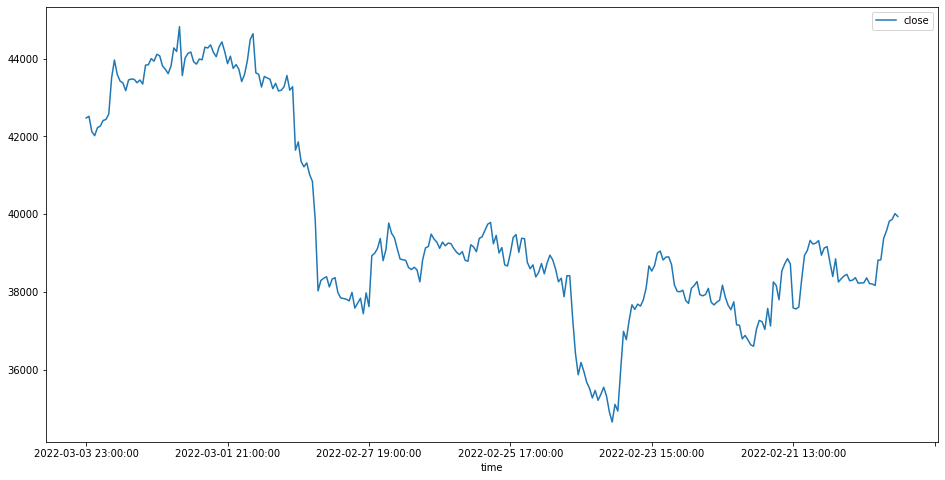

In [60]:
# Plot the dataframe time and volume 
from matplotlib import pyplot as plt


df_volume.plot(x='time', y='close', figsize=(16,8))
plt.show()



# filtered_df.plot(x='time', y='close', figsize=(16, 8), title='DOGE Price')
# plt.show()

In [61]:
# Save DOGE price from filtered_df to a csv file
df_volume.to_csv(f"{path}\BTC_price_history.csv")

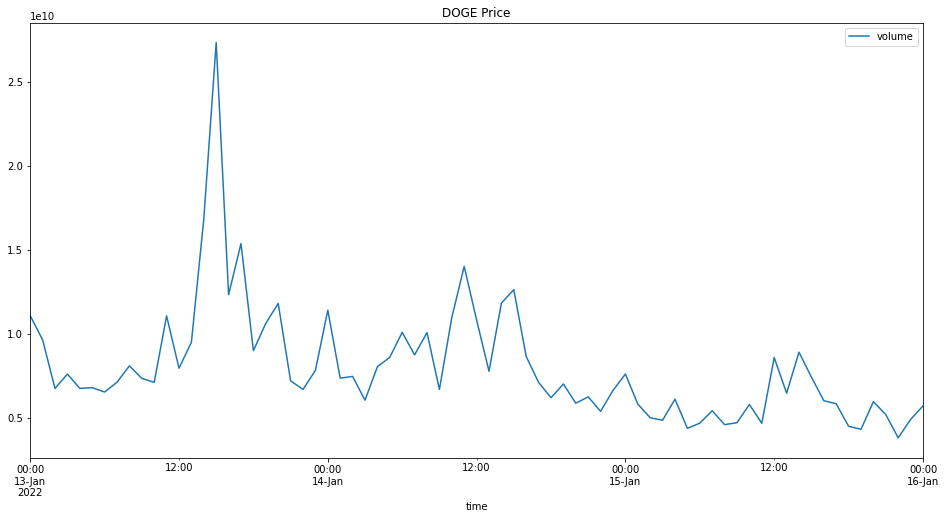

In [48]:
# Plot Values for Jan 14 2022
filtered_df = df_volume[(df_volume['time'] >= '2022-01-13') & (df_volume['time'] <= '2022-01-16' )]
filtered_df.plot(x='time', y='volume', figsize=(16, 8), title='DOGE Price')
plt.show()

In [45]:
print(len(filtered_df))

25
